## TODO

* Show how to create jet images
* Find a clean way to load data from datasets (save to disk?). Check I don't get RAM problems on Colab. can do this with a custom Dataset, but indexing is slow ...

## Imports

In [7]:
from datasets import load_dataset
from fastai.vision.all import *
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms

## Creating jet images

## Load data

In [35]:
images_ds = load_dataset("dl4phys/top_tagging_images")
images_ds

Using custom data configuration dl4phys--top_landscape_images-9b271235338645d2
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
})

In [44]:
%%time
# train_x[:256]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [42]:
%%time
images_ds["train"][:256]

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 14.5 ms


{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
  <PIL.PngImage

## Using dataset

In [68]:
num_samples = 100_000

In [47]:
def convert_to_tensor(x):
    x["pixel_values"] = [transforms.ToTensor()(img) for img in x["image"]]
    x["label"] = [torch.tensor(l).unsqueeze(0) for l in x["label"]]
    return x

In [48]:
images_ds = images_ds.map(convert_to_tensor, batched=True, num_proc=4)

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b450dc0c83c1a67f.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-3089ed3cd2c7fa57.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-8fe848766b132ddd.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-60be1454cd6c9d7f.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-59f55e7e7bbca34e.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-a7acaed6da4dcf15.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-2c763458767ff94d.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-74c910ef6cfcaa80.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-407546ab9ed0b964.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-f9ab346ca267a70b.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-dcb953e4638b49e6.arrow


Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-b7045a46fe6e586f.arrow


In [49]:
images_ds = images_ds.remove_columns("image")

In [69]:
images_ds

DatasetDict({
    validation: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 1211000
    })
})

In [70]:
class JetImageDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        data = self.ds[idx]
        image = torch.tensor(data["pixel_values"]) 
        label = torch.tensor(data["label"]).squeeze() 
        # image = self.ds[idx]["pixel_values"]
        # label = self.ds[idx]["label"]
        return image, label

In [52]:
# %%time
# for i in images_ds["train"].select(range(num_samples)):
#     _ = i

In [71]:
train_ds = JetImageDataset(images_ds["train"].select(range(num_samples)))
valid_ds = JetImageDataset(images_ds["validation"])

In [54]:
train_dl = DataLoader(
    train_ds,
    bs=256,
    shuffle=True,
)
valid_dl = DataLoader(valid_ds, bs=128)

In [55]:
%time
for xb,yb in train_dl:
    _ = 1

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [56]:
train_dl = DataLoader(
    train_ds,
    bs=256,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)
train_dl.to("cuda");

In [21]:
%time
for xb,yb in train_dl:
    _ = 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [15]:
len(train_ds)

10000

In [8]:
train_ds[0][0].device

device(type='cpu')

In [72]:
train_dl = DataLoader(
    train_ds,
    bs=256,
    # shuffle=True,
)
valid_dl = DataLoader(valid_ds, bs=128)

In [72]:
train_dl.to("cuda");
valid_dl.to("cuda");

In [58]:
xb, yb = first(train_dl)

In [59]:
xb.shape, yb.shape

(torch.Size([256, 1, 40, 40]), torch.Size([256]))

In [73]:
dls = DataLoaders(train_dl, valid_dl)
dls.to("cuda");

In [74]:
learn = vision_learner(
    dls,
    resnet18,
    metrics=[accuracy],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

In [75]:
learn.model.to("cuda");

In [76]:
xb, yb = first(dls.loaders[0])

In [77]:
xb.device

device(type='cuda', index=0)

In [78]:
learn.model(xb).device

device(type='cuda', index=0)

SuggestedLRs(valley=0.0012022644514217973)

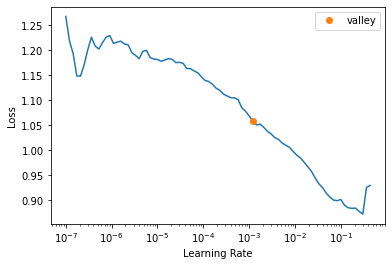

In [79]:
learn.lr_find()

In [80]:
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.514728,0.425086,0.809208,05:41


epoch,train_loss,valid_loss,accuracy,time
0,0.328901,0.292307,0.877146,05:49


## Train simple convnet

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [64]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 16),
    conv(16, 2, act=False),
    Flatten(),
).to("cuda")

In [65]:
simple_cnn(xb).shape

torch.Size([128, 2])

In [66]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

In [67]:
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

SuggestedLRs(valley=0.0030199517495930195)

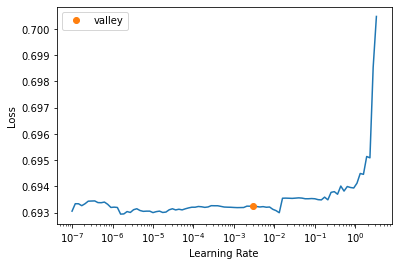

In [68]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-3)

## Train with tensors

In [13]:
num_samples = 10_000

In [14]:
train_ds = images_ds["train"].shuffle()

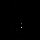

In [15]:
images = train_ds[:num_samples]["image"]
images[0]

In [16]:
labels = train_ds[:num_samples]["label"]

In [17]:
train_x = torch.cat([transforms.ToTensor()(img) for img in images]).unsqueeze(1)
train_y = torch.cat([torch.tensor(l) for l in labels])

In [18]:
train_x.shape, train_y.shape

(torch.Size([10000, 1, 40, 40]), torch.Size([10000]))

In [19]:
class JetTensorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [20]:
train_ds = JetTensorDataset(train_x, train_y)

In [21]:
# train_ds = TensorDataset(train_x, train_y)

In [22]:
train_dl = DataLoader(train_ds, bs=256, shuffle=True)

In [23]:
%%time
for xb,yb in train_dl:
    _ = 1

CPU times: user 57.5 ms, sys: 139 µs, total: 57.7 ms
Wall time: 56.5 ms


In [24]:
len(train_ds)

10000

In [30]:
%%time
for i in train_ds:
    _ = i

CPU times: user 31.2 ms, sys: 29 µs, total: 31.2 ms
Wall time: 30.7 ms


In [25]:
valid_ds = images_ds["validation"].shuffle()
valid_images = valid_ds[:num_samples]["image"]
valid_labels = valid_ds[:num_samples]["label"]

In [26]:
valid_x = torch.cat([transforms.ToTensor()(img) for img in valid_images]).unsqueeze(1)
valid_y = torch.cat([torch.tensor(l) for l in valid_labels])

In [100]:
valid_y[0]

tensor(0)

In [27]:
# valid_ds = TensorDataset(valid_x, valid_y)
valid_ds = JetTensorDataset(valid_x, valid_y)

In [28]:
train_dl = DataLoader(train_ds, bs=256, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False)

In [29]:
xb, yb = first(train_dl)
xb.shape

torch.Size([256, 1, 40, 40])

In [30]:
dls = DataLoaders(train_dl, valid_dl)

### Vision learner

In [31]:
dls.to("cuda");

In [32]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=[accuracy],
    n_in=1,
    n_out=2,
    normalize=False,
    loss_func=F.cross_entropy,
)

In [33]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0012022644514217973)

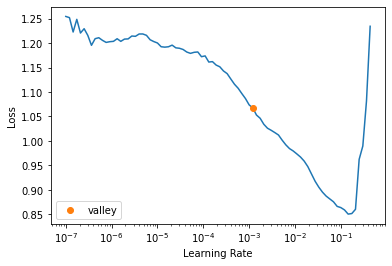

In [34]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.931976,0.669548,0.673500,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.586326,0.497514,0.781100,00:02
1,0.458937,0.431846,0.846900,00:01
2,0.338561,0.415701,0.849700,00:01


In [22]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 16),
    conv(16, 2, act=False),
    Flatten(),
)

In [23]:
simple_cnn(xb).shape

torch.Size([256, 2])

In [27]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

SuggestedLRs(valley=0.0014454397605732083)

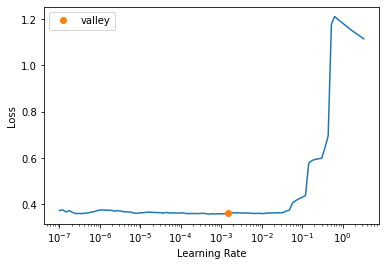

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.310150,0.288318,0.879700,0.950156,00:02
1,0.268565,0.262153,0.889400,0.957021,00:02
2,0.257706,0.252610,0.895000,0.959556,00:02


In [29]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.310150,0.288318,0.879700,0.950156,00:02
1,0.268565,0.262153,0.889400,0.957021,00:02
2,0.257706,0.252610,0.895000,0.959556,00:02


In [30]:
learn = Learner(
    dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy
)

In [32]:
learn.model.to("cuda");

SuggestedLRs(valley=0.0008317637839354575)

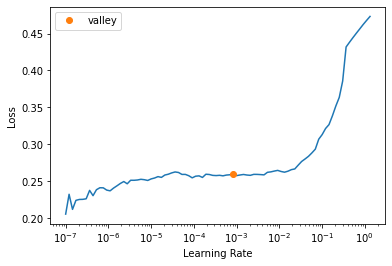

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.262769,0.260341,0.891300,0.959669,00:02
1,0.257183,0.246424,0.898000,0.961613,00:01
2,0.245404,0.241712,0.901200,0.962873,00:01
